[Info] Seed fixed to 42
Device: cuda
Loading 10 subjects from /content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET...

Starting Training...
Epoch 10/100 | Loss: 1625.0914 (Cnt: 1624.2031, Recon: 0.8884, Sp: 0.0009) | MAE: 40.26 | Pred: 0.96 vs GT: 41.22
Epoch 20/100 | Loss: 992.2926 (Cnt: 991.7376, Recon: 0.5544, Sp: 0.0093) | MAE: 31.22 | Pred: 10.00 vs GT: 41.22
Epoch 30/100 | Loss: 450.7931 (Cnt: 450.3943, Recon: 0.3975, Sp: 0.0197) | MAE: 20.06 | Pred: 21.16 vs GT: 41.22
Epoch 40/100 | Loss: 172.3737 (Cnt: 172.0230, Recon: 0.3477, Sp: 0.0479) | MAE: 11.16 | Pred: 51.49 vs GT: 41.22
Epoch 50/100 | Loss: 31.2571 (Cnt: 30.9431, Recon: 0.3116, Sp: 0.0372) | MAE: 4.48 | Pred: 39.95 vs GT: 41.22
Epoch 60/100 | Loss: 34.7940 (Cnt: 34.5065, Recon: 0.2853, Sp: 0.0341) | MAE: 4.99 | Pred: 36.66 vs GT: 41.22
Epoch 70/100 | Loss: 16.0227 (Cnt: 15.7466, Recon: 0.2735, Sp: 0.0404) | MAE: 3.13 | Pred: 43.43 vs GT: 41.22
Epoch 80/100 | Loss: 8.2387 (Cnt: 7.9730, Recon: 0.2633, Sp: 0.0372

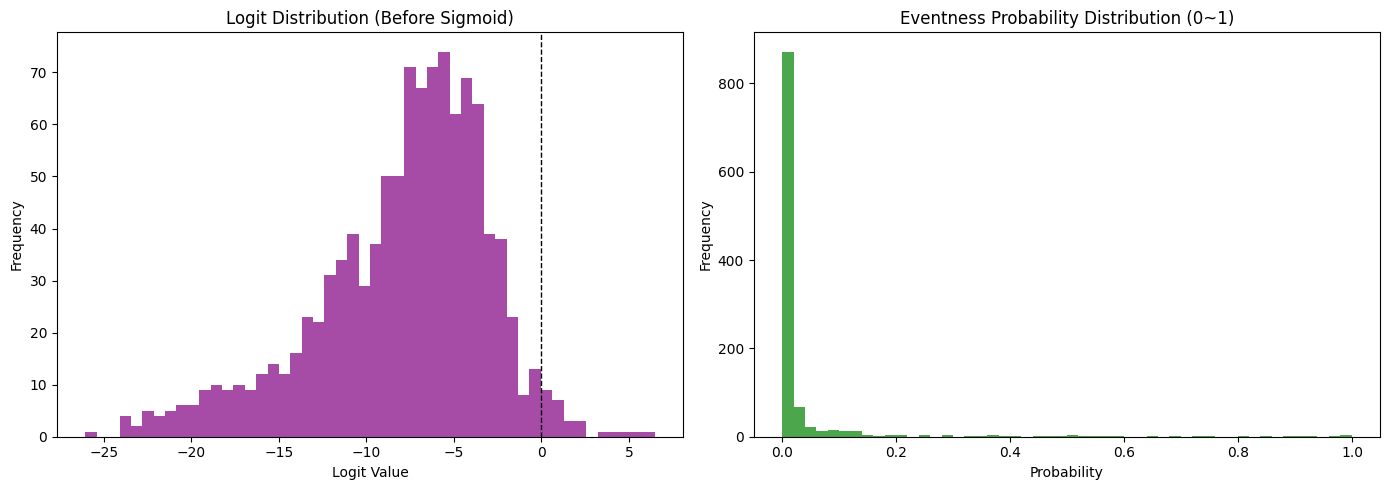

Logit Statistics | Mean: -7.93 | Std: 4.97
               | Min:  -26.05  | Max: 6.47
Ambiguous Logits Ratio (-1 < x < 1): 2.79% (Should be low)


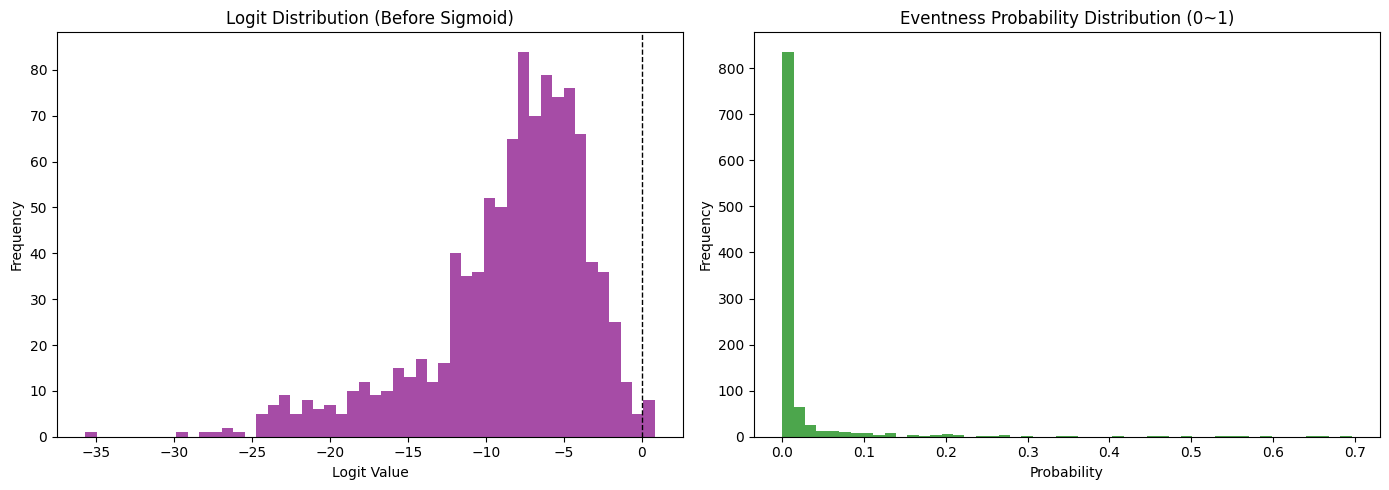

Logit Statistics | Mean: -8.50 | Std: 5.24
               | Min:  -35.71  | Max: 0.83
Ambiguous Logits Ratio (-1 < x < 1): 1.76% (Should be low)


In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ------------------------------------------------------------------------------
# 1. Strict Seeding
# ------------------------------------------------------------------------------
def set_strict_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"[Info] Seed fixed to {seed}")


# ------------------------------------------------------------------------------
# 2. Data Loading
# ------------------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    print(f"Loading {len(file_list)} subjects from {data_dir}...")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset

def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            # Get raw data (N, C)
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Normalize (Z-score per trial)
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,
                'count': float(gt_count),
                'meta': f"{subj}_{act_name}"
            })
        else:
            print(f"[Skip] Missing data for {subj} - {act_name}")

    return trial_list


# ------------------------------------------------------------------------------
# 3. Model Classes
# ------------------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1) # Project to latent
        )

    def forward(self, x):
        # x: (B, C, T)
        z = self.net(x) # (B, D, T)
        z = z.transpose(1, 2) # (B, T, D) for easier handling later
        return z

class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, kernel_size=5, padding=2),
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2),
            nn.GELU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        return self.net(z.transpose(1, 2)) # (B, C, T)
class EventnessHead(nn.Module):
    def __init__(self, latent_dim=3, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, z):
        # z: (B, T, D)
        return self.net(z).squeeze(-1) # (B, T)

class CountModel(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=3):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.event_head = EventnessHead(latent_dim, hidden_dim)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        nn.init.constant_(self.event_head.net[-1].bias, -2.0)

    def forward(self, x, mask=None):
        # x: (B, C, T)
        z = self.encoder(x) # (B, T, D)
        x_hat = self.decoder(z)

        logits = self.event_head(z) # (B, T)
        eventness = torch.sigmoid(logits)

        # Apply mask if provided (to ignore padding)
        if mask is not None:
            mask = mask.to(dtype=eventness.dtype, device=eventness.device)
            eventness = eventness * mask

        count_hat = eventness.sum(dim=1) # (B,)

        return count_hat, eventness, z, x_hat


# ------------------------------------------------------------------------------
# 4. Dataset & Collate
# ------------------------------------------------------------------------------
class TrialDataset(Dataset):
    """
    Wraps the loaded data to provide (sequence, count, meta)
    Compatible with Variable Length Collate
    """
    def __init__(self, trial_list):
        # trial_list: list of dicts {'data': np.array(T, C), 'count': float, 'meta': str}
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1) # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']

def collate_variable_length(batch):
    # batch: list of (data, count, meta)
    # data: (C, T)

    # 1. Find max length
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data = []
    masks = []
    counts = []
    metas = []

    for data, count, meta in batch:
        T = data.shape[1]

        # Pad data
        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data), # (B, C, T_max)
        "mask": torch.stack(masks),       # (B, T_max)
        "count": torch.stack(counts),     # (B,)
        "meta": metas
    }


# ------------------------------------------------------------------------------
# 5. Training
# ------------------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    """
    x_hat, x: (B, C, T)
    mask: (B, T)  (1=유효, 0=pad)
    """
    mask = mask.to(dtype=x.dtype, device=x.device)          # (B,T)
    mask_bc = mask.unsqueeze(1)                             # (B,1,T)
    se = (x_hat - x) ** 2                                   # (B,C,T)
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps                 # B*T_valid*C
    return se.sum() / denom

def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    total_loss = 0
    total_mae = 0
    total_pred = 0
    total_gt = 0

    total_loss_cnt = 0
    total_loss_recon = 0
    total_loss_sp = 0
    total_loss_tv = 0

    lambda_recon = config.get("lambda_recon", 1.0)
    lambda_count = config["lambda_count"]
    lambda_sparse = config["lambda_sparse"]
    lambda_tv = config["lambda_tv"]

    for batch in loader:
        x = batch["data"].to(device)   # (B, C, T)
        mask = batch["mask"].to(device) # (B, T)
        y_true = batch["count"].to(device) # (B,)

        optimizer.zero_grad()

        pred_count, eventness, z, x_hat = model(x, mask)

        # 1. Count Loss (MSE)
        loss_count = F.mse_loss(pred_count, y_true)

        # 2. Reconstruction Loss 계산
        loss_recon = masked_recon_mse(x_hat, x, mask)

        # 3. Sparsity / TV Loss
        loss_sparse = eventness.mean()
        loss_tv = torch.mean(torch.abs(eventness[:, 1:] - eventness[:, :-1]))

        loss = (lambda_count * loss_count +
                lambda_recon * loss_recon +
                lambda_sparse * loss_sparse +
                lambda_tv * loss_tv)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss_cnt += loss_count.item()
        total_loss_recon += loss_recon.item()
        total_loss_sp += loss_sparse.item()
        total_loss_tv += loss_tv.item()

        total_mae += torch.abs(pred_count - y_true).mean().item()
        total_pred += pred_count.mean().item()
        total_gt += y_true.mean().item()

    n = len(loader)
    return (total_loss/n, total_mae/n, total_pred/n, total_gt/n,
            total_loss_cnt/n, total_loss_recon/n, total_loss_sp/n, total_loss_tv/n)


# ------------------------------------------------------------------------------
# 6. Inference
# ------------------------------------------------------------------------------
def evaluation(model, trial_data, feature_names, device, gt_count=None, title="Result"):
    """
    Modified to work with single trial inference
    trial_data: (T, C) numpy array
    """
    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(trial_data, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device) # (1, C, T)
        count_hat, eventness, z, _ = model(x_tensor)
        count_val = count_hat.item()

    gt_str = f"{gt_count:.2f}" if gt_count is not None else "Unknown"

    print("-" * 50)
    print(f"   >>> Test Result | Pred: {count_val:.2f} vs GT: {gt_str}")
    print("-" * 50)

    return count_val


# ------------------------------------------------------------------------------
# 7. Main with CONFIG
# ------------------------------------------------------------------------------
def main():

    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],
        "TARGET_ACTIVITIES_MAP": {
            6: 'Waist bends forward',
            7: 'Frontal elevation of arms',
            8: 'Knees bending',
            12: 'Jump front & back'
        },
        "ACT_FEATURE_MAP": {
            6: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_arm_x', 'acc_arm_y', 'acc_arm_z'],
            7: ['acc_arm_x', 'acc_arm_y', 'acc_arm_z', 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'],
            8: ['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z', 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z'],
            12: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,  # Small batch size since sequences are long

        # Loss Weights
        "lambda_count": 1.0,
        "lambda_sparse": 0.05,
        "lambda_tv": 0.01,

        # Model Arch
        "hidden_dim": 128,
        "latent_dim": 16,

        "TRAIN_LABELS": [
            # (Subject_ID, Activity_ID, True_Count)
            ("subject1", 12, 40),
            ("subject2", 12, 45),
            ("subject3", 12, 42),
            ("subject4", 12, 42),
            ("subject5", 12, 40),
            ("subject6", 12, 42),
            ("subject7", 12, 38),
            ("subject8", 12, 41),
            ("subject9", 12, 41),
        ],

        "TEST_LABELS": [
            ("subject10", 12, 40),
        ]
    }

    # 1. Setup
    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # 2. Load Raw Data
    full_data = load_mhealth_dataset(
        CONFIG["data_dir"],
        CONFIG["TARGET_ACTIVITIES_MAP"],
        CONFIG["COLUMN_NAMES"]
    )

    if not full_data:
        print("No data loaded. Exiting.")
        return

    # 3. Prepare Dataset
    train_data = prepare_trial_list(
        CONFIG["TRAIN_LABELS"],
        full_data,
        CONFIG["TARGET_ACTIVITIES_MAP"],
        CONFIG["ACT_FEATURE_MAP"]
    )

    test_data = prepare_trial_list(
        CONFIG["TEST_LABELS"],
        full_data,
        CONFIG["TARGET_ACTIVITIES_MAP"],
        CONFIG["ACT_FEATURE_MAP"]
    )

    if len(train_data) == 0:
        print("No training data found. Check CONFIG.")
        return

    train_loader = DataLoader(TrialDataset(train_data),
                              batch_size=CONFIG["batch_size"],
                              shuffle=True,
                              collate_fn=collate_variable_length)

    # 4. Model Init
    # Input channels depends on the activity (e.g., Jump has 6 feats)
    input_ch = train_data[0]['data'].shape[1]
    model = CountModel(input_ch=input_ch,
                       hidden_dim=CONFIG["hidden_dim"],
                       latent_dim=CONFIG["latent_dim"]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5) # 30에폭마다 학습률 절반으로

    # 5. Training Loop
    print("\nStarting Training...")
    for epoch in range(CONFIG["epochs"]):
        (avg_loss, avg_mae, avg_pred, avg_gt,
         l_cnt, l_recon, l_sp, l_tv) = train_one_epoch(model, train_loader, optimizer, CONFIG, device)

        scheduler.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
                  f"Loss: {avg_loss:.4f} (Cnt: {l_cnt:.4f}, Recon: {l_recon:.4f}, Sp: {l_sp:.4f}) | "
                  f"MAE: {avg_mae:.2f} | Pred: {avg_pred:.2f} vs GT: {avg_gt:.2f}")

    # 6. Test & Visualize
    print("\n[Inference on Test Set]")
    target_viz_id = 12
    viz_feat_names = CONFIG["ACT_FEATURE_MAP"].get(target_viz_id, ["feat"]*input_ch)

    if len(test_data) > 0:
        for item in test_data:
            print(f"Subject: {item['meta']} | GT Count: {item['count']}")
            evaluation(model, item['data'], viz_feat_names, device, gt_count=item['count'])
    else:
        print("No test data defined. Showing train sample.")
        item = train_data[0]
        evaluation(model, item['data'], viz_feat_names, device, gt_count=item['count'])

    def analyze_logits_distribution(model, trial_data, device):
        model.eval()
        with torch.no_grad():
            # 데이터 준비
            x_tensor = torch.tensor(trial_data['data'], dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)

            # Forward Pass
            # 현재 forward는 z를 리턴하므로, 이를 통해 logit을 역추적하거나 직접 계산
            _, eventness, z, _ = model(x_tensor)

            # Logit 값 직접 계산 (model.event_head의 마지막 레이어 전까지가 logit)
            # Logit = Linear(z)
            logits = model.event_head.net(z).squeeze(-1) # (1, T)

            # Numpy 변환
            logits_np = logits[0].cpu().numpy()
            eventness_np = eventness[0].cpu().numpy()

        # --- 시각화 ---
        plt.figure(figsize=(14, 5))

        # 1. Logit 값의 히스토그램 (가장 중요한 지표)
        plt.subplot(1, 2, 1)
        plt.hist(logits_np, bins=50, color='purple', alpha=0.7)
        plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
        plt.title("Logit Distribution (Before Sigmoid)")
        plt.xlabel("Logit Value")
        plt.ylabel("Frequency")
        # 설명: Peaky Loss가 잘 먹혔다면 0 근처가 텅 비고, 양쪽 끝(-5, +5 등)에 몰려야 함

        # 2. Eventness (Sigmoid 후) 값의 히스토그램
        plt.subplot(1, 2, 2)
        plt.hist(eventness_np, bins=50, color='green', alpha=0.7)
        plt.title("Eventness Probability Distribution (0~1)")
        plt.xlabel("Probability")
        plt.ylabel("Frequency")
        # 설명: 0과 1 근처에만 막대가 솟아 있고, 0.5 부근은 없어야 함

        plt.tight_layout()
        plt.show()

        # --- 통계 수치 출력 ---
        print(f"Logit Statistics | Mean: {logits_np.mean():.2f} | Std: {logits_np.std():.2f}")
        print(f"               | Min:  {logits_np.min():.2f}  | Max: {logits_np.max():.2f}")

        # 0 근처(-1 ~ 1 사이)에 있는 '애매한' 값의 비율 계산
        ambiguous_ratio = np.mean((logits_np > -1) & (logits_np < 1)) * 100
        print(f"Ambiguous Logits Ratio (-1 < x < 1): {ambiguous_ratio:.2f}% (Should be low)")

    # --- 실행 방법 (main 함수 내에서) ---
    analyze_logits_distribution(model, train_data[0], device) # 학습 데이터로 확인
    analyze_logits_distribution(model, test_data[0], device)  # 테스트 데이터로 확인

if __name__ == "__main__":
    main()